## Compute time differences with GMaps routing in no traffic & heavy traffic

In [60]:
import csv

import numpy as np
import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.stats as stats

import osmnx as ox

%matplotlib inline

In [3]:
def read_csv(fname_fast, fname_traffic):
    routes = { }
    
    # Read CSV of fastest routes (no traffic)
    with open(fname_fast, 'r') as f_fast:
        reader = csv.reader(f_fast)
        header = next(reader)
        
        # Configure indices of columns we want
        route_idx = header.index("ID")
        time_idx = header.index("total_time_in_sec")
        nhwdist_idx = header.index("pctNonHighwayDist")
        nhwtime_idx = header.index("pctNonHighwayTime")
        sndist_idx = header.index("pctNeiDist")
        sntime_idx = header.index("pctNeiTime")

        # Store metrics to dictionary with key routeID
        for row in reader:
            if not row: continue

            route_id = row[route_idx]
            routes[route_id] = {
                'time_fast' : float(row[time_idx]),
                'pctNonHighwayDist_fast' : float(row[nhwdist_idx]),
                'pctNonHighwayTime_fast' : float(row[nhwtime_idx]),
                'pctNeiDist_fast' : float(row[sndist_idx]),
                'pctNeiTime_fast' : float(row[sntime_idx])
            }
    
    # Read CSV of routes with traffic
    with open(fname_traffic, 'r') as f_traffic:
        reader = csv.reader(f_traffic)
        header = next(reader)
        
        # Configure indices of columns we want
        route_idx = header.index("ID")
        time_idx = header.index("total_time_in_sec")
        nhwdist_idx = header.index("pctNonHighwayDist")
        nhwtime_idx = header.index("pctNonHighwayTime")
        sndist_idx = header.index("pctNeiDist")
        sntime_idx = header.index("pctNeiTime")

        # Add new metrics to dictionary with key routeID
        for row in reader:
            if not row: continue

            route_id = row[route_idx]
            routes[route_id].update({
                'time_traffic' : float(row[time_idx]),
                'pctNonHighwayDist_traffic' : float(row[nhwdist_idx]),
                'pctNonHighwayTime_traffic' : float(row[nhwtime_idx]),
                'pctNeiDist_traffic' : float(row[sndist_idx]),
                'pctNeiTime_traffic' : float(row[sntime_idx])
            })
    
    return routes

**Time Metrics for Google Maps**

In [4]:
f1FN = "data/chicago_routes_gmaps_fastest_matched.csv"
f2FN = "data/chicago_routes_gmaps_traffic_matched.csv"
routes_gmaps = read_csv(f1FN, f2FN)

In [5]:
# Compute difference in % time spent period, on non-highways, and
# on neighborhood streets from (traffic - default). 
differences_gmaps = { }
for route_id in routes_gmaps:
    try:
        differences_gmaps[route_id] = {
            'diff_time' : routes_gmaps[route_id]['time_traffic'] - routes_gmaps[route_id]['time_fast'],
            'diff_pctNonHighwayTime' : routes_gmaps[route_id]['pctNonHighwayTime_traffic']
                                       - routes_gmaps[route_id]['pctNonHighwayTime_fast'],
            'diff_pctNeiTime' : routes_gmaps[route_id]['pctNeiTime_traffic']
                                - routes_gmaps[route_id]['pctNeiTime_fast']
        }
    except KeyError:
        continue

In [6]:
diffs_time_gmaps = [d['diff_time'] for d in differences_gmaps.values()]
diffs_pctNeiTime_gmaps = [d['diff_pctNeiTime'] for d in differences_gmaps.values()]
diffs_pctNonHighwayTime_gmaps = [d['diff_pctNonHighwayTime'] for d in differences_gmaps.values()]

**Time Metrics for GraphHopper**

In [7]:
f1FN = "data/chicago_routes_gh_fastest.csv"
f2FN = "data/chicago_routes_gh_traffic.csv"
routes_gh = read_csv(f1FN, f2FN)

In [8]:
# Compute difference in % time spent period, on non-highways, and
# on neighborhood streets from (traffic - default). 
differences_gh = { }
for route_id in routes_gh:
    try:
        differences_gh[route_id] = {
            'diff_time' : routes_gh[route_id]['time_traffic'] - routes_gh[route_id]['time_fast'],
            'diff_pctNonHighwayTime' : routes_gh[route_id]['pctNonHighwayTime_traffic']
                                       - routes_gh[route_id]['pctNonHighwayTime_fast'],
            'diff_pctNeiTime' : routes_gh[route_id]['pctNeiTime_traffic']
                                - routes_gh[route_id]['pctNeiTime_fast']
        }
    except KeyError:  # route wasn't processed for both metrics, skip it
        continue

In [9]:
diffs_time_gh = [d['diff_time'] for d in differences_gh.values()]
diffs_pctNeiTime_gh = [d['diff_pctNeiTime'] for d in differences_gh.values()]
diffs_pctNonHighwayTime_gh = [d['diff_pctNonHighwayTime'] for d in differences_gh.values()]

**Comparing Time Spent off Highways**

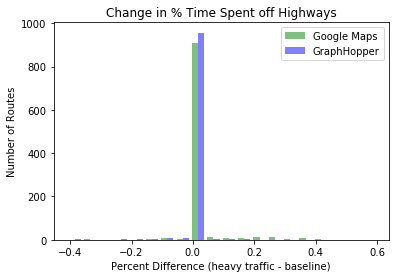

In [29]:
plt.hist([diffs_pctNonHighwayTime_gmaps, diffs_pctNonHighwayTime_gh],
         bins = 20, color = ['g', 'b'], alpha = 0.5, width = 0.02,
         label = ['Google Maps', 'GraphHopper'])
plt.legend(loc='upper right')
plt.title('Change in % Time Spent off Highways')
plt.xlabel('Percent Difference (heavy traffic - baseline)')
plt.ylabel('Number of Routes')

In [27]:
np.mean(diffs_pctNonHighwayTime_gh), stats.ttest_1samp(diffs_pctNonHighwayTime_gh, 0)

(-0.0018650000000000003,
 Ttest_1sampResult(statistic=-1.768946352867661, pvalue=0.077207913298854791))

In [26]:
np.mean(diffs_pctNonHighwayTime_gmaps), stats.ttest_1samp(diffs_pctNonHighwayTime_gmaps, 0)

(0.012376376376376378,
 Ttest_1sampResult(statistic=5.5799740364762984, pvalue=3.0982973468031511e-08))

In [11]:
stats.ttest_ind(diffs_pctNonHighwayTime_gh, diffs_pctNonHighwayTime_gmaps)

Ttest_indResult(statistic=-5.8008554812664892, pvalue=7.6534888399134442e-09)

We see that while Google Maps is more likely to direct people off highways in heavy traffic (t = 5.8), this does not seem to be a significant effect in GraphHopper traffic routing (t = 1.8). The two are noticeably different from each other, however (t = -5.8).

**Comparing Time Spent on Neighborhood Roads**

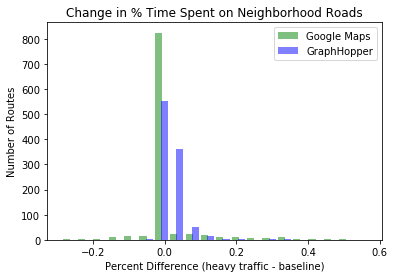

In [62]:
plt.hist([diffs_pctNeiTime_gmaps, diffs_pctNeiTime_gh],
         bins = 20, color = ['g', 'b'], alpha = 0.5, width = 0.02,
         label = ['Google Maps', 'GraphHopper'])
plt.legend(loc='upper right')
plt.title('Change in % Time Spent on Neighborhood Roads')
plt.xlabel('Percent Difference (heavy traffic - baseline)')
plt.ylabel('Number of Routes')

In [30]:
np.mean(diffs_pctNeiTime_gh), stats.ttest_1samp(diffs_pctNeiTime_gh, 0)

(0.018533999999999998,
 Ttest_1sampResult(statistic=16.077655648988266, pvalue=6.6709334647266976e-52))

In [31]:
np.mean(diffs_pctNeiTime_gmaps), stats.ttest_1samp(diffs_pctNeiTime_gmaps, 0)

(0.016062062062062062,
 Ttest_1sampResult(statistic=6.1547007118584087, pvalue=1.0879160742265571e-09))

In [12]:
stats.ttest_ind(diffs_pctNeiTime_gh, diffs_pctNeiTime_gmaps)

Ttest_indResult(statistic=0.86672950620750711, pvalue=0.38619435887573572)

This gives support to the original result that alternative routing schemes may result in increased neighborhood traffic. We observe this in both Google Maps and GraphHopper (t = 16.1 in GraphHopper and t = 6.15 in Google Maps). The two are not significantly different from each other.

# Street Level Differences

In [63]:
ox.graph_from_bbox(north = 41.6445431223, south = 42.023039, east = -87.5241371039, west= -87.940114)


KeyboardInterrupt: 